# More on Neural Networs with PyTorch

**CE477: Machine Learning**

__Instructor:__ Dr. Ali Sharifi-Zarchi

__Author:__ Ramtin Moslemi

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharifiZarchi/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_03_Neural_Networks/More_on_NNs_with_Torch.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/SharifiZarchi/Introduction_to_Machine_Learning/main/Jupyter_Notebooks/Chapter_03_Neural_Networks/More_on_NNs_with_Torch.ipynb)



---

## Notebook Objectives

In this notebook we are going to explore some of the more advanced features of PyTorch.


## Imports and Setup

In this notebook we are going to work with the [MedMNIST](https://medmnist.com/) dataset. For simplicity, we are going to install medmnist so that it would be easier to work with it.

In [ ]:
! pip install medmnist

Once again we must import our libraries. Notice that we are going to use `ChestMNIST` which is a dataset of *Chest X-Rays*.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
from tqdm import trange
from medmnist import ChestMNIST
from matplotlib import pyplot as plt
from sklearn.metrics import hamming_loss, accuracy_score, precision_recall_fscore_support, average_precision_score

In [3]:
# @title plotting helper function
def plot_results(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

To accelerate operations in the neural network, we move it to the GPU or MPS (for Apple silicon) if available.

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Loading the Data

To work with the data we must first download the dataset using `ChestMNIST`. We will normalize our data as well to get better results during training.

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_dataset = ChestMNIST(split='train', transform=transform, download=True)
test_dataset = ChestMNIST(split='test', transform=transform, download=True)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Train dataset size: 78468
Test dataset size: 22433


Next we must get the dataloaders. Perhaps you recall from our [previous notebook](https://colab.research.google.com/github/SharifiZarchi/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_03_Neural_Networks/NNs_with_torch.ipynb), we didn't use validation sets. However in this notebook we are going to learn how we can use validation sets in PyTorch using `random_split` from `torch.utils.data`. In order to keep the rest of the notebooks shorter and to the point, we will not use validation sets in later notebooks.

In [6]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 62774
Validation dataset size: 15694
Test dataset size: 22433


While we could now proceed with our datasets, since the [MedMNIST](https://medmnist.com/) dataset provides validation sets itself, we are going to use its data.

In [7]:
test_dataset = ChestMNIST(split='train', transform=transform, download=False)
val_dataset = ChestMNIST(split='val', transform=transform, download=True)
test_dataset = ChestMNIST(split='test', transform=transform, download=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Training dataset size: 62774
Validation dataset size: 11219
Testing dataset size: 22433


Same as before, we can make the dataloaders. Notice that we don't shuffle our validation and test sets but we do shuffle the training set.

In [8]:
# Create the dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Now lets see the dimensions of the data.

In [9]:
# Iterate over the data
for x, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64, 14]) torch.int64


# Neural Network

This time we are going to use batch normalization layers and leaky relu activation functions.

In [10]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)


# Training

To implement our training code more clearly, we are going to implement the following functions:


*   `train_step`: By running this function we train the model for a single epoch.
*   `test_step`: By running this function we will evaluate the models performance on the given dataloader without training the model.
*   `train_model`: This function will use the aforementioned functions to fully train the model and evaluate the results.






In [11]:
def train_step(model, criterion, optimizer, dataloader=train_loader, device=device):
    running_loss = 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = criterion(pred, y.float())
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Clear the gradients
        optimizer.zero_grad()
        # Update the running loss
        running_loss += loss.item()
    # Calculate and return the average loss
    return running_loss / len(dataloader)


def test_step(model, criterion, dataloader=val_loader, device=device):
    running_loss = 0
    # Move the model to training mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Compute prediction error
          loss = criterion(pred, y.float())
          # Update the running loss
          running_loss += loss.item()
    # Calculate and return the average loss
    return running_loss / len(dataloader)

Now we have to implement the `train_model` function.

In [12]:
def train_model(model, n_epochs, optimizer, criterion, train_loader, val_loader, device=device):
    train_losses, val_losses = [], []
    for epoch in (pbar := trange(n_epochs)):
        # Train the model
        train_loss = train_step(model, criterion, optimizer, train_loader, device)
        # Evaluate the model
        val_loss = test_step(model, criterion, val_loader, device)
        # Display the results
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Val Loss = {val_loss:.3f} ')
        # Store the results
        train_losses.append(train_loss), val_losses.append(val_loss)
    # Plot the results
    plot_results(train_losses, val_losses)
    return train_losses, val_losses

All that remains for us to do is to define the loss metric and the optimizer to train the model.

In [13]:
model = SimpleNN(input_size=28*28, num_classes=14).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train Loss = 0.16 | Val Loss = 0.17 : 100%|██████████| 20/20 [06:14<00:00, 18.70s/it]


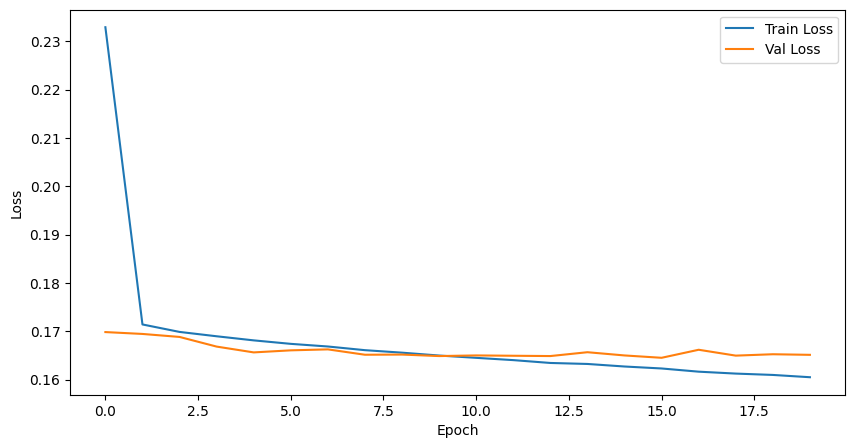

In [14]:
results = train_model(model, 20, optimizer, criterion, train_loader, val_loader)

# Evaluation

In [15]:
def evaluate_model(model, data_loader, device=device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    hamming = hamming_loss(all_labels, all_preds > 0.5)
    subset_acc = accuracy_score(all_labels, all_preds > 0.5)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds > 0.5, average='macro')
    avg_precision = average_precision_score(all_labels, all_preds, average='macro')

    print(f'Hamming Loss: {hamming}')
    print(f'Subset Accuracy: {subset_acc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1}')
    print(f'Average Precision: {avg_precision}')

    return {
        'Hamming Loss': hamming,
        'Subset Accuracy': subset_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Average Precision': avg_precision
    }

In [16]:
metrics = evaluate_model(model, test_loader)

Hamming Loss: 0.05276028300144558
Subset Accuracy: 0.5292649222128115
Precision: 0.18296276579233142
Recall: 0.010666848834182186
F1-Score: 0.018267924618030115
Average Precision: 0.12447987886638169


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Saving and Loading Models

Now we turn our attention to saving and loading models. First we will save the model we just trained.

In [17]:
# Save the model
torch.save(model.state_dict(), 'chestmnist_model.pth')

We can then load the model once again.

In [20]:
# Load the model
net = SimpleNN(input_size=28*28, num_classes=14).to(device)
net.load_state_dict(torch.load('chestmnist_model.pth'))

<ipython-input-20-974580418a2e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('chestmnist_model.pth'))


<All keys matched successfully>

If we evalute the loaded model once more, you will see that they have similar results.

In [21]:
metrics = evaluate_model(net, test_loader, device)

Hamming Loss: 0.05276028300144558
Subset Accuracy: 0.5292649222128115
Precision: 0.18296276579233142
Recall: 0.010666848834182186
F1-Score: 0.018267924618030115
Average Precision: 0.12447987886638169


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
